In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.colors as mcolors

%load_ext autoreload
%autoreload 2

In [2]:
all_df = pd.read_csv('../data/relaxometry_results_240816.csv', index_col=None)
all_df['Session'] = all_df['Session'].astype(str)

In [3]:
def make_linear_fit(x,y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    cfi = results.conf_int().loc['x1'].values
    r = results.params.x1

    return r, results, cfi, iv_l, iv_u

def filter_df(df, sub, ses, seg, quant):
    return df.query("Session==@ses & Subject==@sub & Segmentation==@seg & Quant==@quant")

def make_relax_plot(sub, x, y, ax, x_label, y_label):
    r, results, cfi, iv_l, iv_u = make_linear_fit(x,y)
    l = ax.plot(x, y, 'o')
    color = l[0].get_color()
    l = ax.plot(x, results.fittedvalues, '--', color=color, label=rf'({sub}) $r_{1}={r:.3} \pm {results.bse.x1:.1}$')
    ax.fill_between(x, iv_u, iv_l, alpha=0.2, color=color)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.axis([0,None,0,None])
    return r, results, l


In [4]:
sub = 'P0004'
ses = '230224'

# NiCl2
dfT1 = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='T1').reset_index(drop=True).sort_values(by='LabelValue')
dfT2 = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='T2').reset_index(drop=True).sort_values(by='LabelValue')

df_nicl = pd.DataFrame(columns=['Mimic', 'Content', 'Conc. [mM]', 'T1 [s]', 'T2 [s]'])
df_nicl['Mimic'] = [f'T1 {i}' for i in range(1,15)]
df_nicl['Content'] = 'NiCl2'
df_nicl['Conc. [mM]'] = dfT1['Concentration']
df_nicl['T1 [s]'] = dfT1['Median']
df_nicl['T2 [s]'] = dfT2['Median']

# MnCl2
dfT1 = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='T1').reset_index(drop=True).sort_values(by='LabelValue')
dfT2 = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='T2').reset_index(drop=True).sort_values(by='LabelValue')

df_mncl = pd.DataFrame(columns=['Mimic', 'Content', 'Conc. [mM]', 'T1 [s]', 'T2 [s]'])
df_mncl['Mimic'] = [f'T2 {i}' for i in range(1,15)]
df_mncl['Content'] = 'MnCl2'
df_mncl['Conc. [mM]'] = dfT1['Concentration']
df_mncl['T1 [s]'] = dfT1['Median']
df_mncl['T2 [s]'] = dfT2['Median']

# PVP
dfT1 = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T1').reset_index(drop=True).sort_values(by='LabelValue')
dfT2 = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T2').reset_index(drop=True).sort_values(by='LabelValue')

df_adc = pd.DataFrame(columns=['Mimic', 'Content', 'Conc. [mM]', 'T1 [s]', 'T2 [s]', 'ADC'])
df_adc['Mimic'] = [f'ADC {i}' for i in range(1,15)]
df_adc['Content'] = 'PVP'
df_adc['Conc. [mM]'] = dfT1['Concentration']
df_adc['T1 [s]'] = dfT1['Median']
df_adc['T2 [s]'] = dfT2['Median']
df_adc['ADC'] = dfT1['ADC']

pvp_adc = {0.0:2393, 10.0:1884, 20.0:1439, 30.0:1047, 40.0:654, 50.0:388}

df_adc.rename(columns={'ADC': r'ADC (um2/s)'}, inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


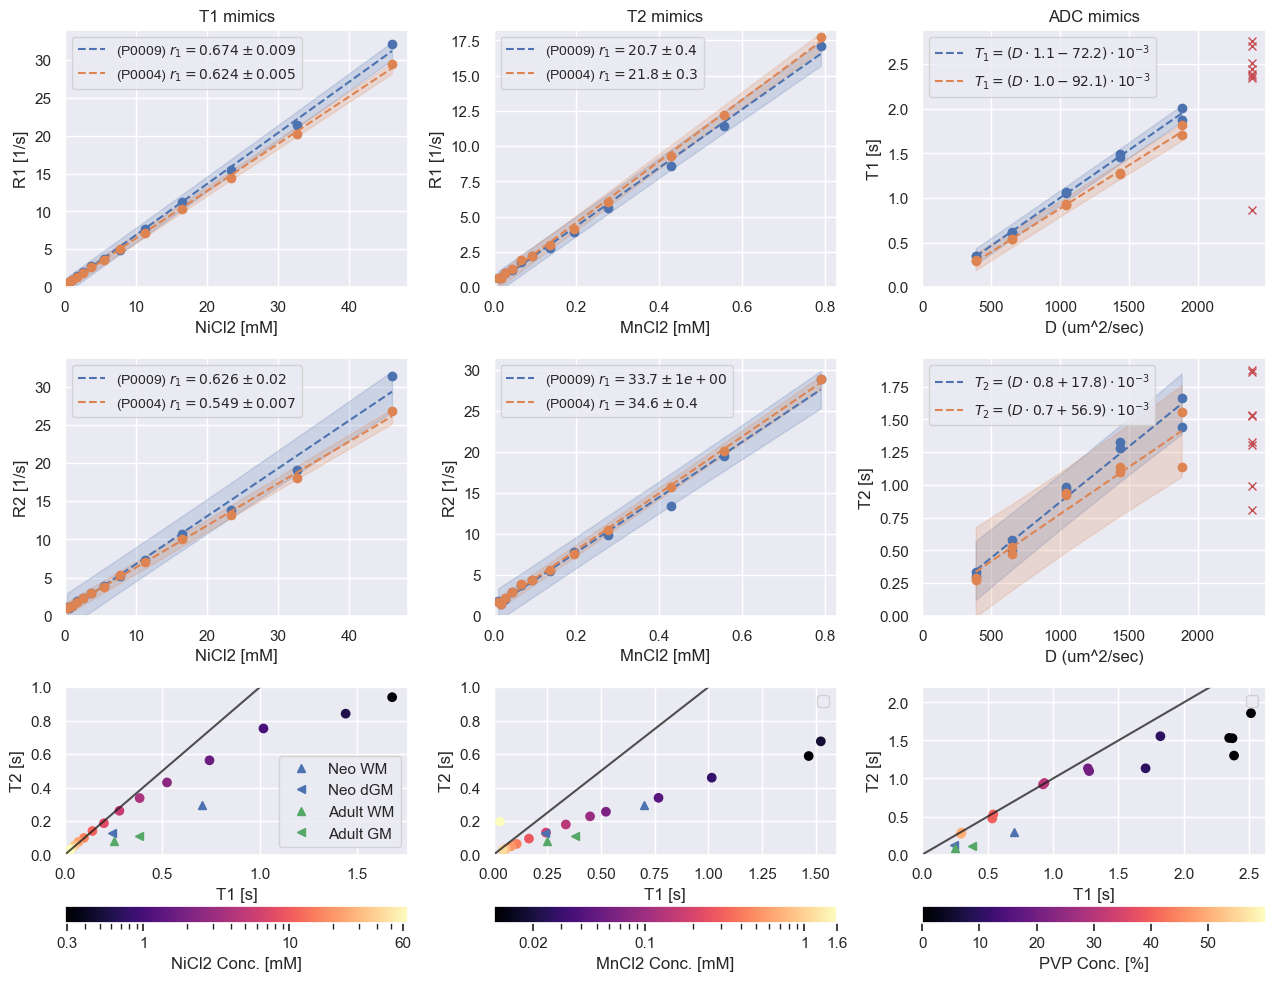

In [5]:
NiCl_thr = 60
MnCl_thr = 1

sns.set_theme()

fig, axes = plt.subplots(3,3, figsize=(13,10))

subjects = ['P0009', 'P0004']
sessions = ['20240708', '230224']

for sub,ses in zip(subjects, sessions):

    ### R1 T1 mimics ###
    df = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='R1')
    df = df.query('Concentration<@NiCl_thr')
    # [(df['Concentration']<NiCl_thr)]
    x = np.array(df['Concentration'])
    y = df['Median']
    make_relax_plot(sub, x, y, ax=axes[0,0], y_label='R1 [1/s]', x_label='NiCl2 [mM]')
    
    ### R1 T2 mimics ###
    df = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='R1')
    df = df.query('Concentration<@MnCl_thr')
    x = np.array(df['Concentration'])
    y = df['Median']
    make_relax_plot(sub, x, y, ax=axes[0,1], y_label='R1 [1/s]', x_label='MnCl2 [mM]')


    ### T1 ADC mimics ###
    df = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T1').sort_values(by='ADC')

    df_filt = df.query('ADC<2000')
    df_0 = df.query('ADC>2000')
    x = np.array(df_filt['ADC'])
    y = df_filt['Median']
    l = axes[0,2].plot(df_0['ADC'], df_0['Median'], 'xr')
    r, results, l = make_relax_plot(sub, x, y, ax=axes[0,2], x_label='D (um^2/sec)', y_label='T1 [s]')
    l[0].set_label(fr'$T_1=(D\cdot{results.params.x1*1E3:.1f}{results.params.const*1E3:.1f})\cdot 10^{{-3}}$')


    ### R2 T1 mimics ###
    df = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='R2')
    df = df.query('Concentration < @NiCl_thr')
    x = np.array(df['Concentration'])
    y = df['Median']
    make_relax_plot(sub, x, y, ax=axes[1,0], x_label='NiCl2 [mM]', y_label='R2 [1/s]')
    
    ### R2 T2 mimics ###
    df = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='R2')
    df = df.query('Concentration < @MnCl_thr')
    x = np.array(df['Concentration'])
    y = df['Median']
    make_relax_plot(sub, x, y, ax=axes[1,1], x_label='MnCl2 [mM]', y_label='R2 [1/s]')
    

    ### T2 ADC mimics ###
    df = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T2').sort_values(by='ADC')
    
    df_filt = df.query('ADC<2000')
    df_0 = df.query('ADC>2000')
    x = np.array(df_filt['ADC'])
    y = df_filt['Median']
    
    axes[1,2].plot(df_0['ADC'], df_0['Median'], 'xr')
    r, results, l = make_relax_plot(sub, x, y, ax=axes[1,2], x_label='D (um^2/sec)', y_label='T2 [s]')
    l[0].set_label(fr'$T_2=(D\cdot{results.params.x1*1E3:.1f}+{results.params.const*1E3:.1f})\cdot 10^{{-3}}$')
    

labels = ['A','B','C','D','E','F']
for i,ax in enumerate(axes.flatten()):
    ax.legend(fontsize=10, loc='upper left')

axes[0,0].set_title('T1 mimics')
axes[0,1].set_title('T2 mimics')
axes[0,2].set_title('ADC mimics')

cmap = plt.get_cmap('magma')
#### T1 ####
norm = mcolors.LogNorm(vmin=df_nicl['Conc. [mM]'].min(), vmax=df_nicl['Conc. [mM]'].max())
sc = axes[2,0].scatter(df_nicl['T1 [s]'], df_nicl['T2 [s]'], c=df_nicl['Conc. [mM]'], cmap=cmap, norm=norm)
axes[2,0].set_xlabel('T1 [s]')
axes[2,0].set_ylabel('T2 [s]')

cb = plt.colorbar(sc, ax=axes[2,0], label='NiCl2 Conc. [mM]', orientation='horizontal', pad=.2)
ticks = [0.3, 1, 10, 60]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x}" for x in ticks])

#### T2 ####
norm = mcolors.LogNorm(vmin=df_mncl['Conc. [mM]'].min(), vmax=df_mncl['Conc. [mM]'].max())
sc = axes[2,1].scatter(df_mncl['T1 [s]'], df_mncl['T2 [s]'], c=df_mncl['Conc. [mM]'], cmap=cmap, norm=norm)
axes[2,1].set_xlabel('T1 [s]')
axes[2,1].set_ylabel('T2 [s]')

cb = plt.colorbar(sc, ax=axes[2,1], label='MnCl2 Conc. [mM]', orientation='horizontal', pad=.2)
ticks = [0.02, .1, 1, 1.6]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x}" for x in ticks])

#### ADC ####
norm = mcolors.Normalize(vmin=df_adc['Conc. [mM]'].min(), vmax=60)
sc = axes[2,2].scatter(df_adc['T1 [s]'], df_adc['T2 [s]'], c=df_adc['Conc. [mM]'], cmap=cmap, norm=norm)
axes[2,2].set_xlabel('T1 [s]')
axes[2,2].set_ylabel('T2 [s]')

cb = plt.colorbar(sc, ax=axes[2,2], label='PVP Conc. [%]', orientation='horizontal', pad=.2)
ticks = [0,10,20,30,40,50]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x}" for x in ticks])

axes[2,0].axis([0,None,0,1])
axes[2,1].axis([0,None,0,1])
axes[2,2].axis([0,None,0,2.2])

# Normal tissue relaxivity times
adult_WM = {'T1':.250, 'T2':.080}
adult_GM = {'T1':.380,'T2':.110}
                
# At PMA=40
neo_WM = {'T1':.702,'T2':.294}
neo_dGM = {'T1':.240,'T2':.130}

for ax in [axes[2,0], axes[2,1], axes[2,2]]:
    ax.plot(neo_WM['T1'], neo_WM['T2'], '^', color='C00', label='Neo WM')
    ax.plot(neo_dGM['T1'], neo_dGM['T2'], '<', color='C00', label='Neo dGM')
    ax.plot(adult_WM['T1'], adult_WM['T2'], '^', color='C02', label='Adult WM')
    ax.plot(adult_GM['T1'], adult_GM['T2'], '<', color='C02', label='Adult GM')

axes[2,0].plot([0,1], [0,1], '-k', zorder=1, alpha=0.75)
axes[2,1].plot([0,1], [0,1], '-k', zorder=1, alpha=0.75)
axes[2,2].plot([0,2.2], [0,2.2], '-k', zorder=1, alpha=0.75)

axes[2,0].grid(True, zorder=-10)
axes[2,0].legend()
axes[2,1].legend([])
axes[2,2].legend([])

plt.tight_layout()
plt.savefig('../results/relaxometry.png')
plt.show()

In [6]:
df_adc.to_csv('../results/relaxometry_PVP_mimics.csv')
df_mncl.to_csv('../results/relaxometry_MnCl_mimics.csv')
df_nicl.to_csv('../results/relaxometry_NiCl_mimics.csv')